We have the cost function 
$$J(0,Z_t,J_t) =  E [ \int_{0}^{T} [(Z_t - B_t)^2 + c_1 B_t^2 + c_2 J_t^2 ] dt

    + g(T)]
$$


$$g(T) = c_3  J_t^2$$
$Z_t = X_t- m_t,J_t = I_t - \frac{I_{max}}{2}$

The solution is $$u=-\kappa (P_3(t)-1)x-\kappa P_4(t)y$$
with 
$$\dot{P_3}=(\alpha+\kappa P_4)P_3-\kappa P_4,P_3(T)=0$$

$$\dot{P_4}=\kappa P^2_4-c_2,P_4(T)=c_3$$
$$\kappa=\frac{1}{1+c_1}$$
We rely on numerical ODE solver. At each time step, we only require once computation of $P_4,P_3$ for all $x,y$. So it is not too bad.




In [1]:
import numpy as np
from scipy.integrate import odeint
def P_4(y,t,running_Bpen,running_Ipen):
    const_1 = 1/(1+running_Bpen)
    const_2 = running_Ipen
    dp4_dt = const_1* y**2-const_2
    return dp4_dt

def P_3(y,t,P_4t,alpha,running_Bpen):
    const_1 = alpha +  P_4t/(1+running_Bpen)
    const_2 = 1/(1+running_Bpen)
    dP3_dt = const_1*y -const_2*P_4t
    return dP3_dt

def control(running_Bpen,P3_t,P4_t,x,y):
    unscaled_control =  (P3_t-1)* x + P4_t*y
    scaled_control =- unscaled_control/(1+running_Bpen)
    return scaled_control

def plot_controlmap(ax,t,T,mean_rev_rate,X_max,I_mid,Bmax,running_Bpen,running_Ipen,terminal_Ipen):
    x_range = np.linspace(-X_max,X_max,100)
    y_range = np.linspace(-I_mid,I_mid,100)
    X, Y = np.meshgrid(x_range, y_range) 
    control_map = np.empty_like(X)
    t_range = np.linspace(T,t,1000)
    # sets P_4(T) = c_3, numerically compute and get P_4(t)
    P_4t=  odeint(P_4,terminal_Ipen,t_range,args=(running_Bpen,running_Ipen)).flatten()[-1]
    # sets P_3(T) = 0, numerically compute and get P_3(t)
    P_3t= odeint(P_3,0,t_range,args=(P_4t,mean_rev_rate,running_Bpen)).flatten()[-1]


    # Iterate over each element in themeshgrid
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):

            dt = 1 
            I_max = 2*I_mid
            # Y is tau, so make sure u do Y+X to get T
            LB = np.maximum(-Bmax, -(Y[i,j]+I_mid)/dt);
            UB = np.minimum(Bmax, (I_max-Y[i,j]-I_mid)/dt)
            control_map[i,j] = np.maximum(LB,np.minimum(control(running_Bpen,P_3t,P_4t,X[i,j],Y[i,j]),UB))
    y_range = np.linspace(0,8,100)
    if ax is not None:
        X, Y = np.meshgrid(x_range, y_range) 
        ax.plot_surface(X, Y, control_map)
        ax.view_init(45, 130)
        ax.set_xlabel('X (MW)', fontsize=12)
        ax.set_ylabel('I (MWh)', fontsize=12)
    # returns the case I_range, and  X_max
    return np.min(control_map[25:50,-1])

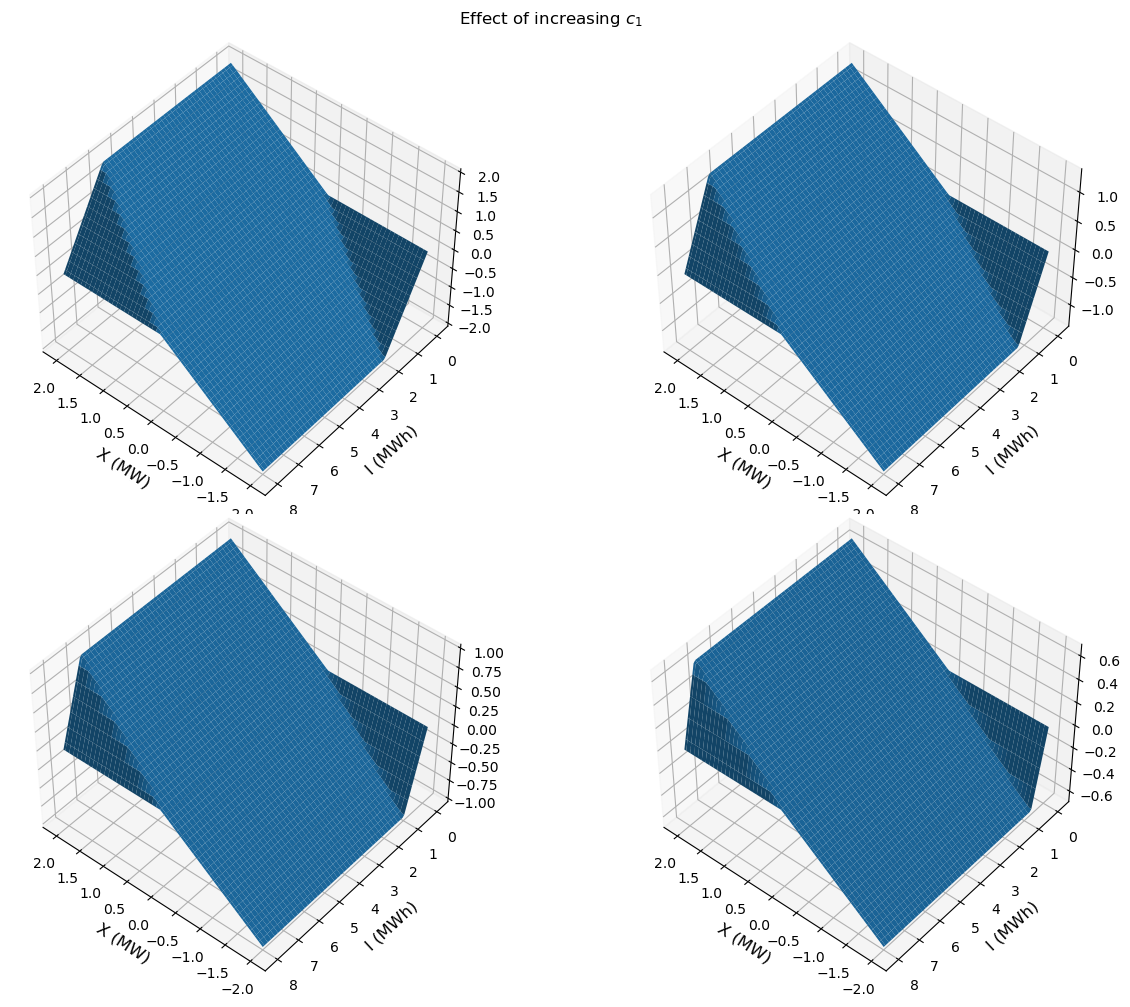

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221,projection= "3d")
ax2 = fig.add_subplot(222,projection= "3d")
ax3 = fig.add_subplot(223,projection= "3d")
ax4 = fig.add_subplot(224,projection= "3d")
plot_controlmap(ax1,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.0001,terminal_Ipen=0.001)
plot_controlmap(ax2,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.5,running_Ipen=0.0001,terminal_Ipen=0.001)
plot_controlmap(ax3,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=1,running_Ipen=0.0001,terminal_Ipen=0.001)
plot_controlmap(ax4,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=2,running_Ipen=0.0001,terminal_Ipen=0.001)
fig.suptitle(r"Effect of increasing $c_1$")
fig.tight_layout()

Text(0, 0.5, 'b')

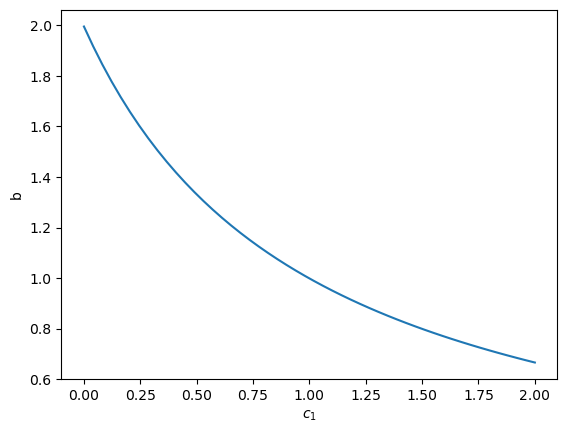

In [3]:
running_B_pen = np.linspace(0,2,50)
u_maxs = []

for B_pen in running_B_pen:
    u_max = plot_controlmap(None,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=B_pen,running_Ipen=0.0001,terminal_Ipen=0.0001)
    u_maxs.append(u_max)

plt.plot(running_B_pen,u_maxs)
plt.xlabel(r"$c_1$")
plt.ylabel(r"b")

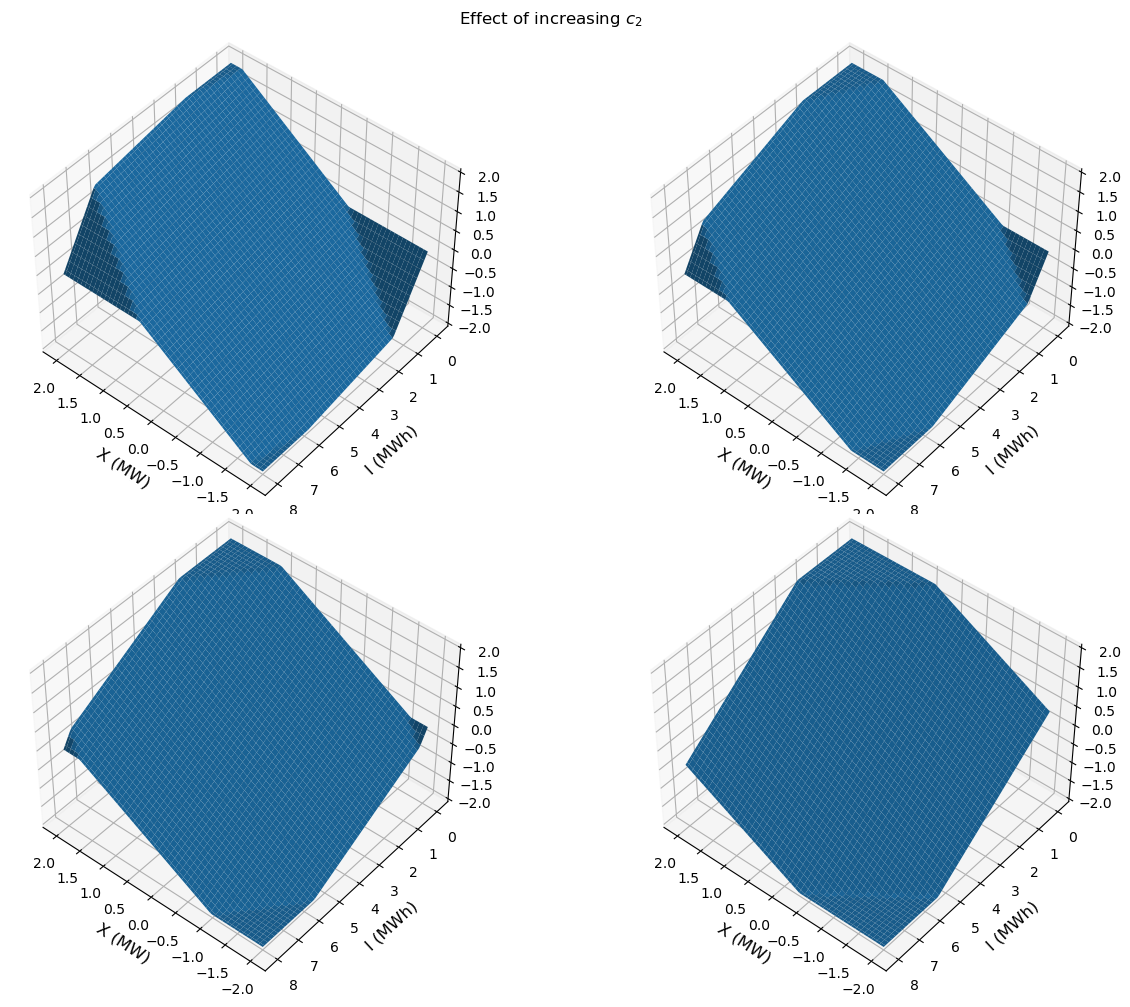

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221,projection= "3d")
ax2 = fig.add_subplot(222,projection= "3d")
ax3 = fig.add_subplot(223,projection= "3d")
ax4 = fig.add_subplot(224,projection= "3d")
plot_controlmap(ax1,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.01,terminal_Ipen=0.0001)
plot_controlmap(ax2,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.05,terminal_Ipen=0.0001)
plot_controlmap(ax3,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.1,terminal_Ipen=0.0001)
plot_controlmap(ax4,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.2,terminal_Ipen=0.0001)
fig.suptitle(r"Effect of increasing $c_2$")
fig.tight_layout()

Text(0, 0.5, 'b')

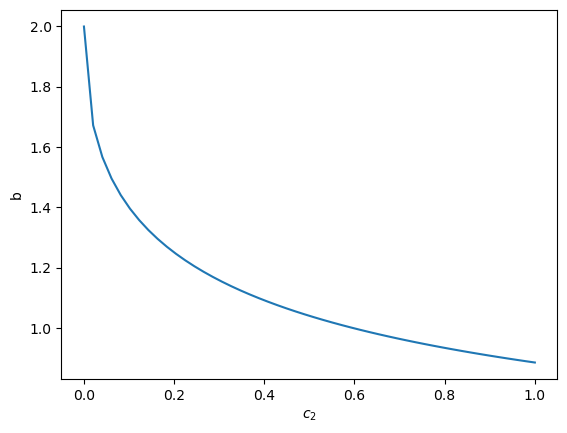

In [5]:
running_I_pen = np.linspace(0,1,50)
u_maxs = []

for I_pen in running_B_pen:
    u_max = plot_controlmap(None,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=I_pen,terminal_Ipen=0.0001)
    u_maxs.append(u_max)

plt.plot(running_I_pen,u_maxs)
plt.xlabel(r"$c_2$")
plt.ylabel(r"b")

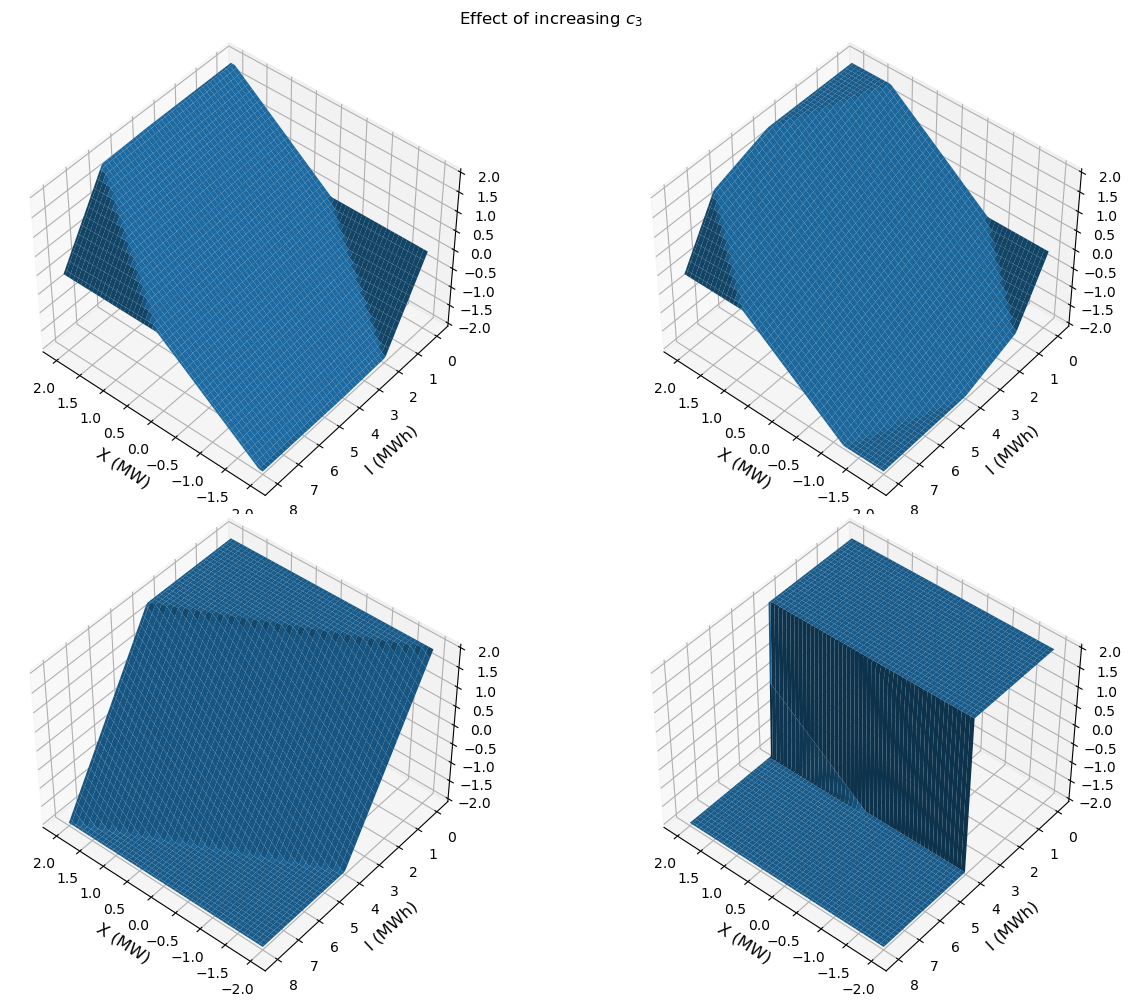

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221,projection= "3d")
ax2 = fig.add_subplot(222,projection= "3d")
ax3 = fig.add_subplot(223,projection= "3d")
ax4 = fig.add_subplot(224,projection= "3d")
plot_controlmap(ax1,t=24,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.0001,terminal_Ipen=0.02)
plot_controlmap(ax2,t=24,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.0001,terminal_Ipen=0.2)
plot_controlmap(ax3,t=24,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.0001,terminal_Ipen=1)
plot_controlmap(ax4,t=24,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.0001,running_Ipen=0.0001,terminal_Ipen=50)
fig.suptitle(r"Effect of increasing $c_3$")
fig.tight_layout()



# Heuristic approximation of GP control map

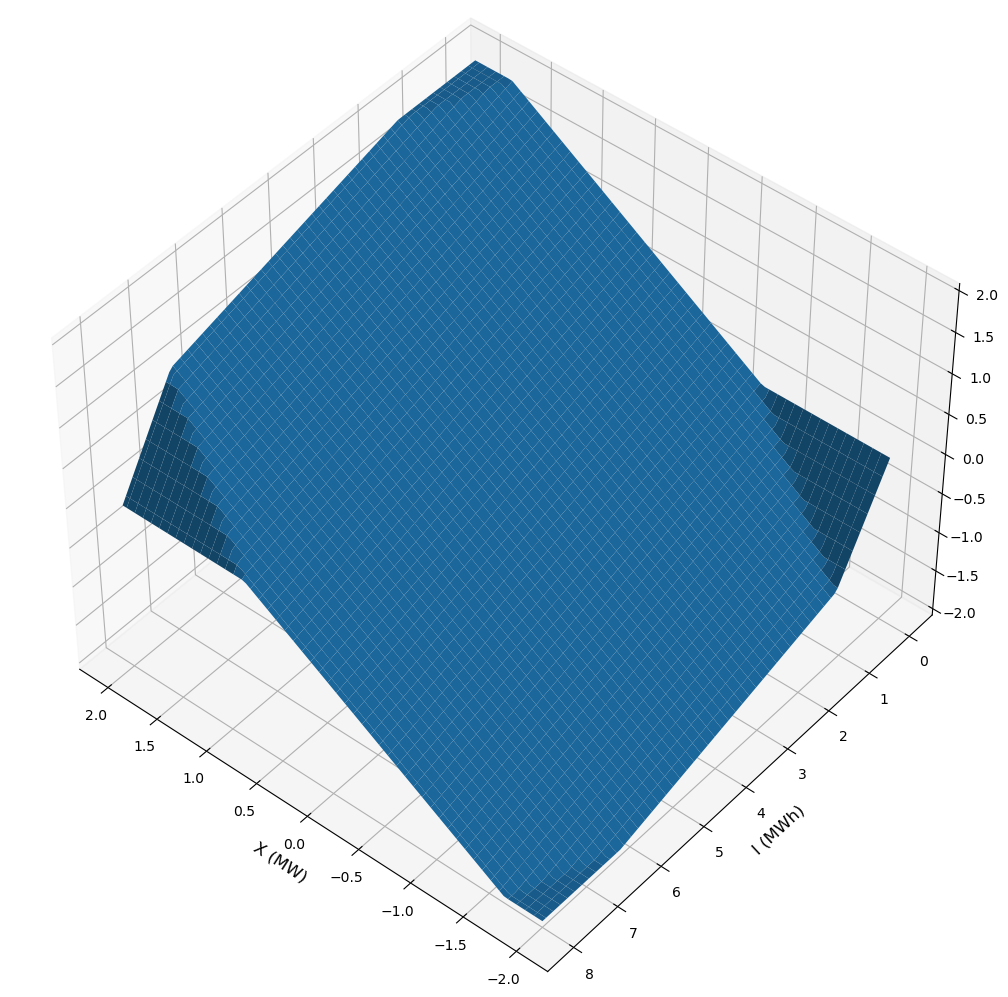

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111,projection= "3d")

plot_controlmap(ax1,t=0,T=24,mean_rev_rate=1,X_max=2,I_mid=4,Bmax=2,running_Bpen=0.051515151515151514,running_Ipen=0.028571428571428574,terminal_Ipen=1)


fig.tight_layout()